# Quantitative Easing and Tapering
In response to the financial crisis of 2008, since March 2009 the Fed has been playing an active role in buying large quantities of federal debt and mortgage bonds and holding them on its books thereby increasing the monetary base (each purchase triggering an increase in reserve balances) and applying downward pressure on long-term interest rates. This process has become known as _quantitiative easing_. As a result, the percentage of US federal debt held by US federal reserve banks increased from about 8% in 2007 to a whopping 20.8% in 2021.

Since June 2022 the Fed has embarked on a tapering exercise whereby it allowed upto USD 30 billion in Treasury and USD 17.5 billion in mortgage bonds to mature every month without reinvesting the proceeds (a passive _runoff_, aka quantitative tightening). Each maturing bond whose notional the Fed is not reinvesting decreases the amount of reserves and hence the monetary base. In September 2022 the Fed increased the runoff to upto USD 60 billion in Treasuries and USD 35 billion in mortgage bonds. The Fed reduced the runoff to upto USD 25 billion in Treasuries from June 2024 leaving the target for mortgage bonds intact at USD 35 billion (with a twist that it will reinvest any excess mortgage bond principal payments into Treasuries, which it was not doing before). From April 2025 onward the Fed further reduced the runoff in Treasuries to just USD 5 billion, leaving the target for mortgage bonds at USD 35 billion.

From December 2025 onward the Fed stopped the runoff of treasury securities. The runoff of mortgage bonds continues, however all redeemed notionals will get reinvested into treasury securities. This implies that these operations will not reduce the amount of bank reserves. This in fact concludes quantitative tightening. From December 11, 2025<sup>th</sup> the Fed increased the System Open Market Account holdings of securities through purchases of Treasury bills and, if needed, other Treasury securities with remaining maturities of 3 years or less to maintain an ample level of reserves.

In this notebook I examine the composition of securities held outright by the Fed as well its speed of increasing or decreasing their ownership by the Fed (in Billions per month).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date
from pandas.tseries.offsets import MonthBegin, Day
from pandas.tseries.holiday import USFederalHolidayCalendar

In [2]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()

# Limit the display of dataframes to 25 rows max
pd.options.display.max_rows = 25

# Indicate representation in Billions
pd.options.display.float_format = '${:,.2f}bn'.format

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org) for this analysis:
* `WSHOTSL` &mdash; Assets: Securities Held Outright: U.S. Treasury Securities: Wednesday Level (weekly frequency)
* `WSHOMCB` &mdash; Assets: Securities Held Outright: Mortgage-Backed Securities: Wednesday Level (weekly frequency)
* `WSHOFADSL` &mdash; Assets: Securities Held Outright: Federal Agency Debt Securities: Wednesday Level (weekly frequency)
* `WLCFLL` &mdash; Assets: Liquidity and Credit Facilities: Loans: Wednesday Level (weekly frequency)
* `WORAL`&mdash; Assets: Repurchase Agreements: Wednesday Level (weekly frequency)

**NB:** These data series return the face value of these securities. The Fed uses [the Effective Interest Method](https://www.investopedia.com/ask/answers/063015/what-effective-interest-method-amortization.asp) of accounting for debt securities it holds. The unamortied differences between the face value and the purchase price are held in the _Unamortized premiums on securities held outright_ and _Unamortized discounts on securities held outright_ accounts (which can be obtained from the `WUPSHO` and `WUDSHO` series respectively).

In [3]:
sec_held_outright = web.get_data_fred(['WSHOTSL', 'WSHOMCB', 'WSHOFADSL', 'WLCFLL', 'WORAL'],
                                      start=report_start, end=report_end).asfreq('W-Wed')

# Converting into billions of USD
sec_held_outright /= 1000.

In [4]:
sec_held_outright.rename(
    columns={'WSHOTSL': 'US Treasury Securities', 'WSHOMCB': 'Mortgage-Backed Securities',
             'WSHOFADSL': 'Federal Agency Debt Securities', 'WLCFLL': 'Loans',
             'WORAL': 'Repurchase Agreeents'},
    inplace=True)

In [5]:
SEC_HELD_OUTRIGHT_COMPOSITION_TITLE = 'Federal Reserve Banks: Securities held outright (at face value)'
SEC_HELD_OUTRIGHT_AND_LOANS_COMPOSITION_TITLE = SEC_HELD_OUTRIGHT_COMPOSITION_TITLE + ' and Emergency Loans'
SEC_HELD_OUTRIGHT_SPEED = 'Speed of Quantitative Easing or Tapering in Billions of USD per month'
SEC_HELD_OUTRIGHT_SPEED_MA = 'Speed of Quantitative Easing or Tapering in Billions of USD per month (moving average over one quarter)'
LEFT_Y_AXIS_LABEL = 'Billions of USD'
LEFT_Y_AXIS_LABEL_SPEED = 'Billions of USD per Month'

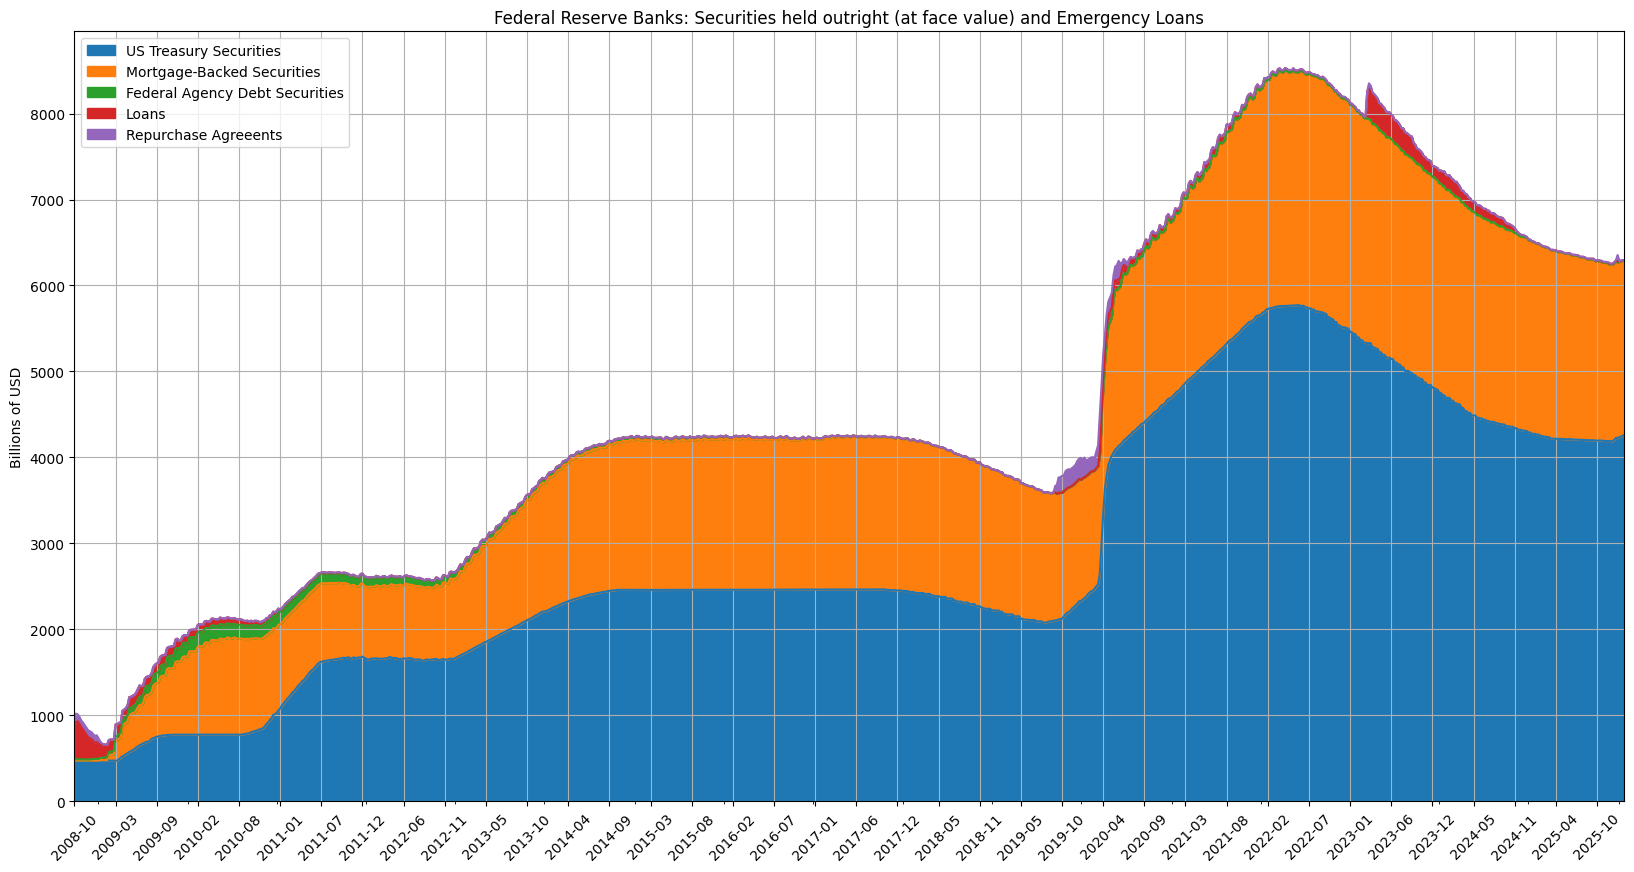

In [6]:
ax = sec_held_outright.plot.area(figsize=(20,10), grid=True, title=SEC_HELD_OUTRIGHT_AND_LOANS_COMPOSITION_TITLE,
                          xticks=sec_held_outright.index[::24], xlabel='', rot=45,
                          ylabel=LEFT_Y_AXIS_LABEL) #, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright.index[::24])))

In [7]:
# This piece of code caters to edge cases where a Wednesday falls on the start of a month and also happens to be a public
# holiday in the US. In this case it's correct to attribute the level of securities held by the Fed on that Wednesday
# to the end of the previous month.
non_bd_ms_index = sec_held_outright.loc[
        np.busday_count(sec_held_outright.index.map(MonthBegin(0).rollback).values.astype('datetime64[D]'),
                        (sec_held_outright.index + Day(1)).values.astype('datetime64[D]'),
                        holidays=USFederalHolidayCalendar().holidays().values.astype('datetime64[D]')) == 0].index
non_bd_ms_pos = non_bd_ms_index.map(sec_held_outright.index.get_loc).drop(0, errors='ignore')
sec_held_outright.iloc[non_bd_ms_pos - 1] = sec_held_outright.iloc[non_bd_ms_pos]
sec_held_outright.drop(sec_held_outright.index[non_bd_ms_pos], inplace=True)

In [8]:
# Resampling to month start
sec_held_outright = sec_held_outright.resample('MS').last()

In [9]:
sec_held_outright

,US Treasury Securities,Mortgage-Backed Securities,Federal Agency Debt Securities,Loans,Repurchase Agreeents
DATE,,,,,
2008-10-01,$476.47bn,$0.00bn,$13.62bn,$369.76bn,$80.00bn
2008-11-01,$476.41bn,$0.00bn,$12.22bn,$259.05bn,$80.00bn
2008-12-01,$475.92bn,$0.00bn,$19.71bn,$193.87bn,$80.00bn
2009-01-01,$475.13bn,$7.38bn,$28.36bn,$154.79bn,$0.00bn
2009-02-01,$474.64bn,$68.75bn,$38.34bn,$138.90bn,$0.00bn
...,...,...,...,...,...
2025-09-01,"$4,201.21bn","$2,099.22bn",$2.35bn,$8.51bn,$0.00bn
2025-10-01,"$4,196.74bn","$2,069.96bn",$2.35bn,$8.01bn,$10.31bn
2025-11-01,"$4,191.23bn","$2,053.66bn",$2.35bn,$7.88bn,$14.00bn


### Measuring the speed of quantitative easing/tapering in Billions of USD per month

In [10]:
sec_held_outright_speed = (sec_held_outright - sec_held_outright.shift(1)).dropna()

In [11]:
sec_held_outright_speed.loc['2020-01':, sec_held_outright_speed.columns[[0,1,3,4]]].tail(12)

,US Treasury Securities,Mortgage-Backed Securities,Loans,Repurchase Agreeents
DATE,,,,
2025-02-01,$-23.17bn,$-14.25bn,$0.00bn,$0.09bn
2025-03-01,$-13.92bn,$-14.31bn,$-1.25bn,$-0.10bn
2025-04-01,$-21.61bn,$-16.05bn,$1.21bn,$0.11bn
2025-05-01,$-2.08bn,$-16.78bn,$-1.49bn,$-0.11bn
2025-06-01,$-1.11bn,$-17.66bn,$4.20bn,$0.01bn
2025-07-01,$-5.70bn,$-17.82bn,$-0.96bn,$-0.02bn
2025-08-01,$-4.57bn,$-17.83bn,$-1.39bn,$0.02bn
2025-09-01,$-1.14bn,$-3.63bn,$2.85bn,$-0.02bn
2025-10-01,$-4.47bn,$-29.25bn,$-0.50bn,$10.31bn


##### Limiting the range of the Y axis for better display

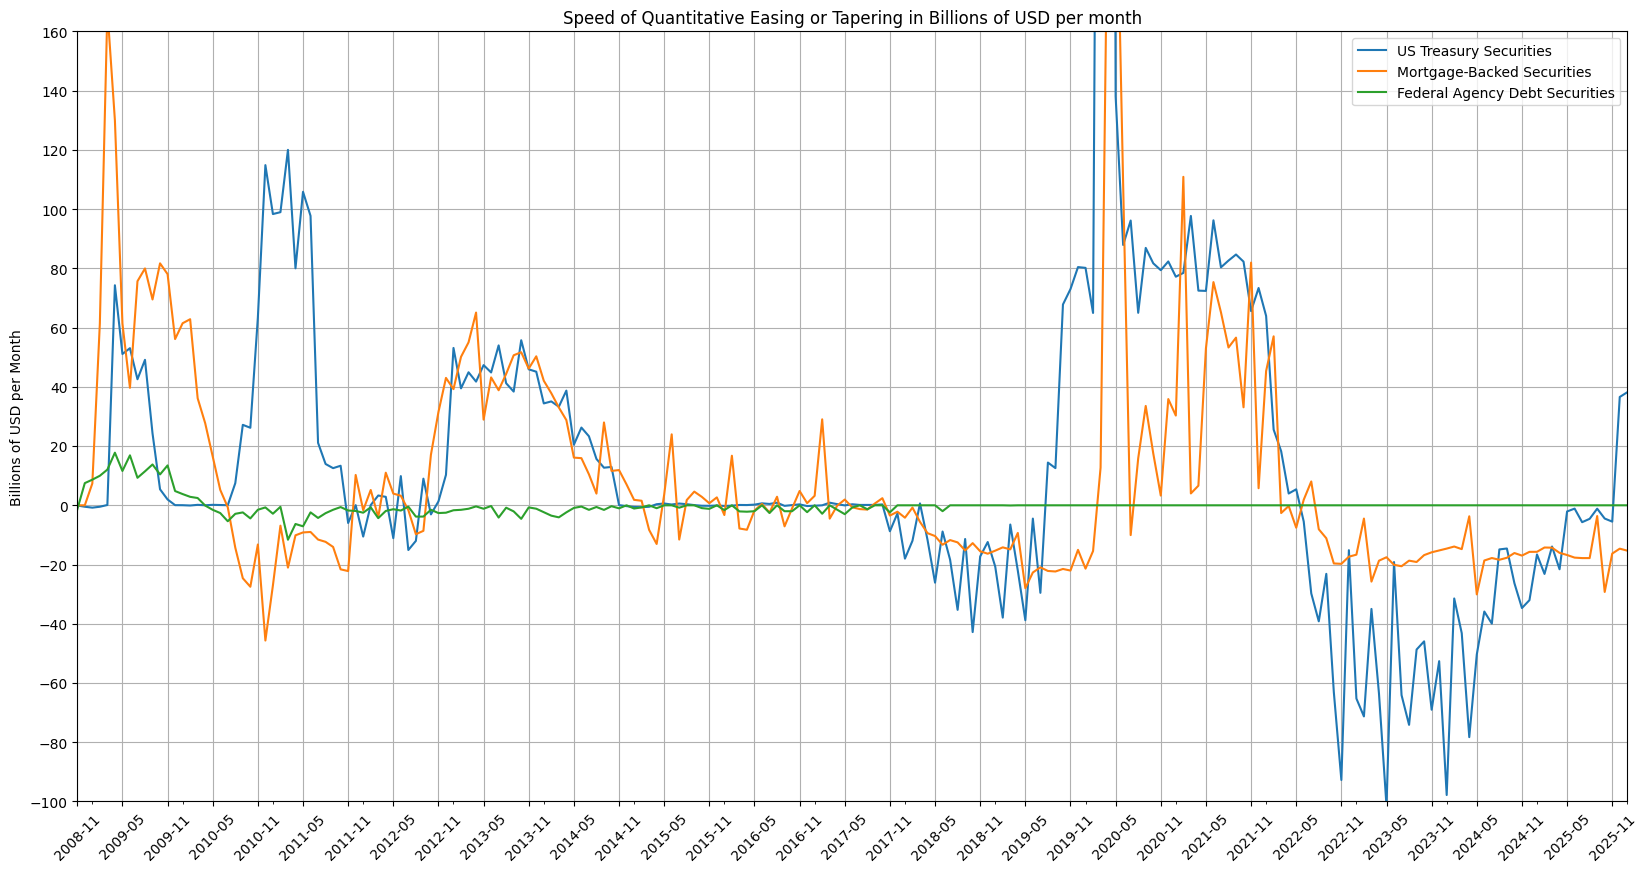

In [12]:
ax = sec_held_outright_speed.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED,
                            xticks=sec_held_outright_speed.index[::6], xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED, ylim=(-100, 160), yticks=np.arange(-100, 161, 20))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed.index[::6])))

#### Zomming in on the last two years

In [13]:
sec_held_outright_speed_short = sec_held_outright_speed.loc['2021':]

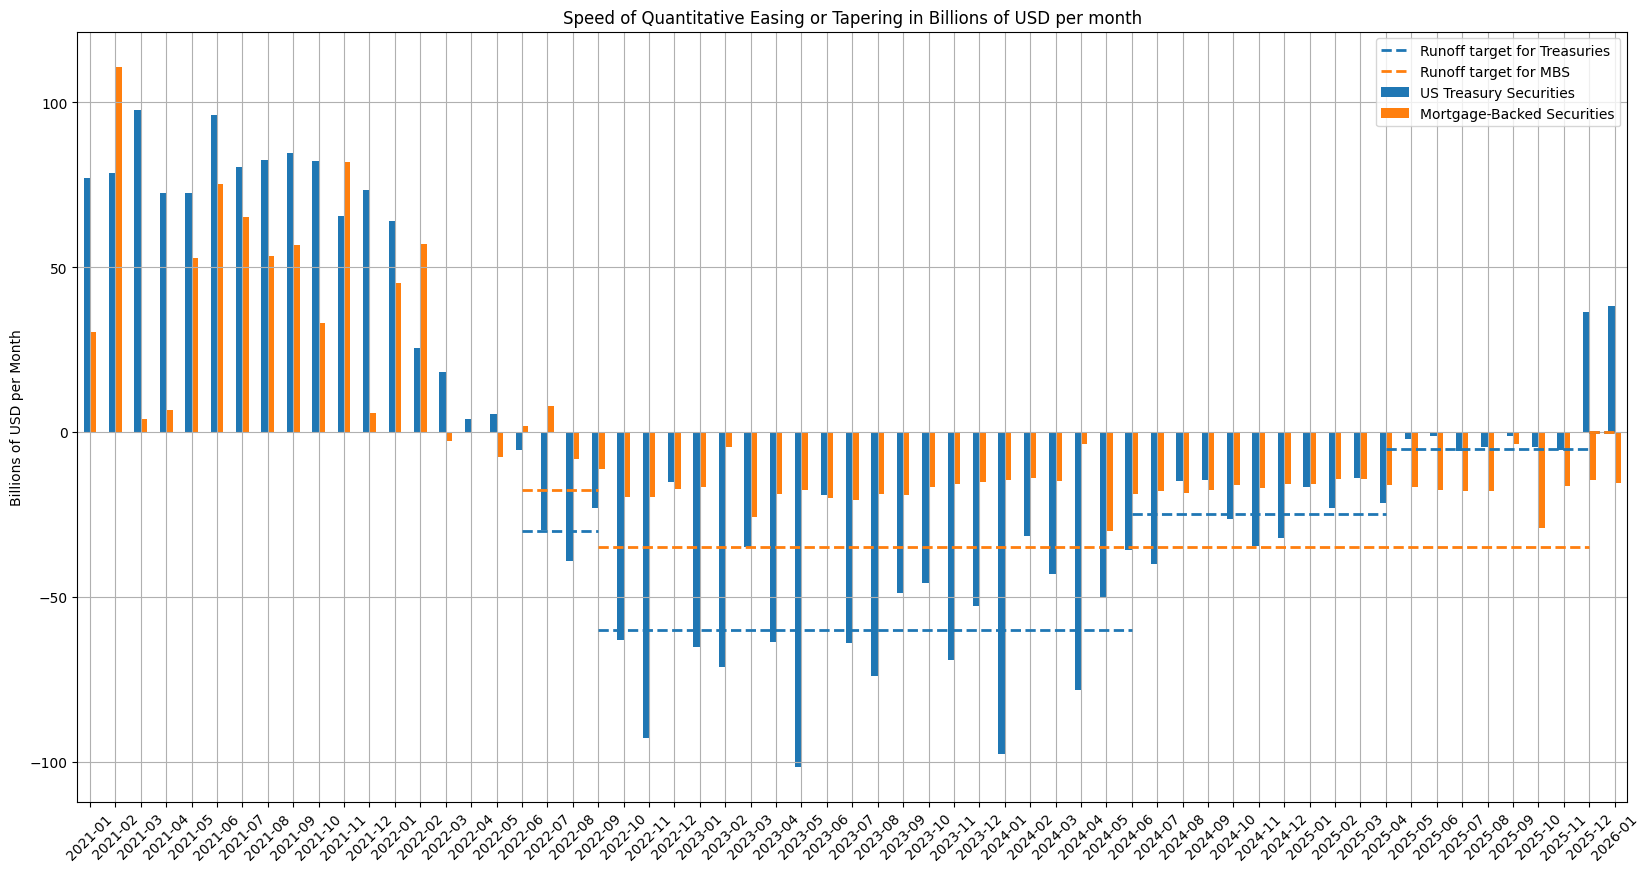

In [14]:
# Determine the index positions of the dates related to quantitative tightening
x1, x2, x3, x4, x5 = sec_held_outright_speed_short.index.get_indexer(['2022-06', '2022-09', '2024-06', '2025-04', '2025-12'])

# Replace to show loans issued under the Bank Term Funding Program and other emergency loans
# ax = sec_held_outright_speed_short.iloc[:,[0,1,3]].plot.bar(figsize=(20,10), grid=True,
ax = sec_held_outright_speed_short.iloc[:,[0,1]].plot.bar(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED, 
                            xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)
# Translate them into coordinates
ax.hlines(y=[-30, -60, -25, -5, 0], xmin=[x1, x2, x3, x4, x5], xmax=[x2, x3, x4, x5, sec_held_outright_speed_short.index.size-1],
          linestyles='--', lw=2, colors='#1f77b4', label='Runoff target for Treasuries')
ax.hlines(y=[-17.5, -35, 0], xmin=[x1, x2, x5], xmax=[x2, x5, sec_held_outright_speed_short.index.size-1],
          linestyles='--', lw=2, colors='#ff7f0e', label='Runoff target for MBS')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed_short.index)))

#### Measuring the speed of quantitative easing/tapering in Billions of USD/month represented as a moving average over one quarter

In [15]:
sec_held_outright_speed_ma = sec_held_outright_speed.rolling(3).mean().dropna()

In [16]:
sec_held_outright_speed_ma.loc['2020-01':, sec_held_outright_speed_ma.columns[:2]]

,US Treasury Securities,Mortgage-Backed Securities
DATE,,
2020-01-01,$77.87bn,$-19.49bn
2020-02-01,$75.19bn,$-17.29bn
2020-03-01,$216.48bn,$-8.04bn
2020-04-01,$520.77bn,$72.48bn
2020-05-01,$545.15bn,$154.42bn
...,...,...
2025-09-01,$-3.80bn,$-13.09bn
2025-10-01,$-3.39bn,$-16.90bn
2025-11-01,$-3.71bn,$-16.39bn


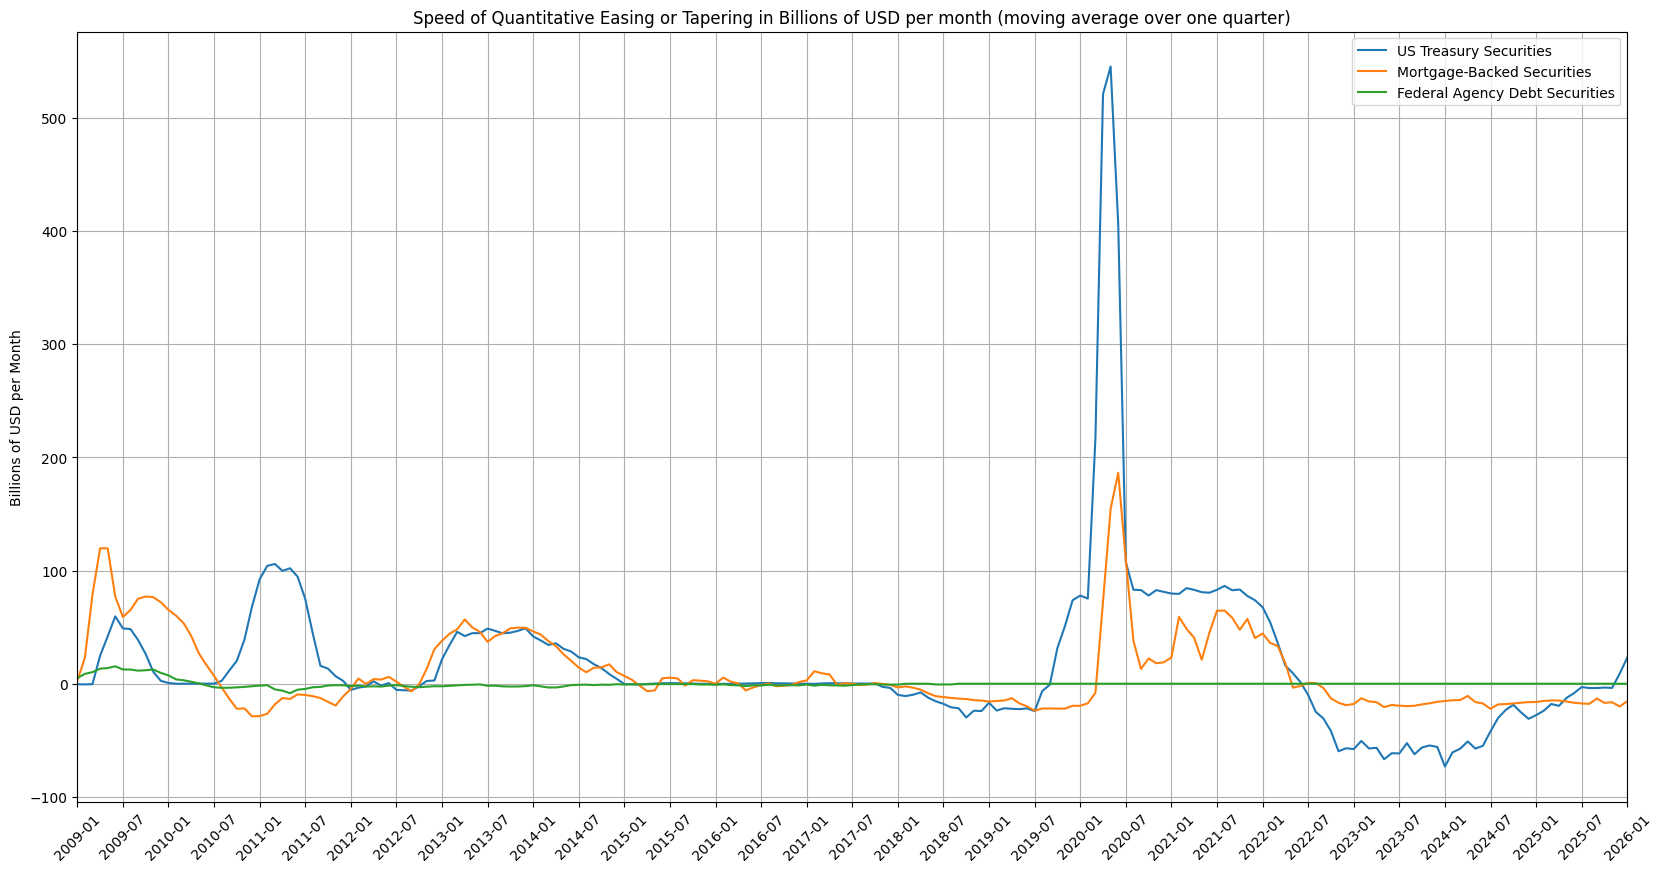

In [17]:
ax = sec_held_outright_speed_ma.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED_MA,
                            xticks=sec_held_outright_speed_ma.index[::6], xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED)#, yticks=np.arange(-30, 21, 5))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed_ma.index[::6])))

##### Limiting the range of the Y axis for better display.

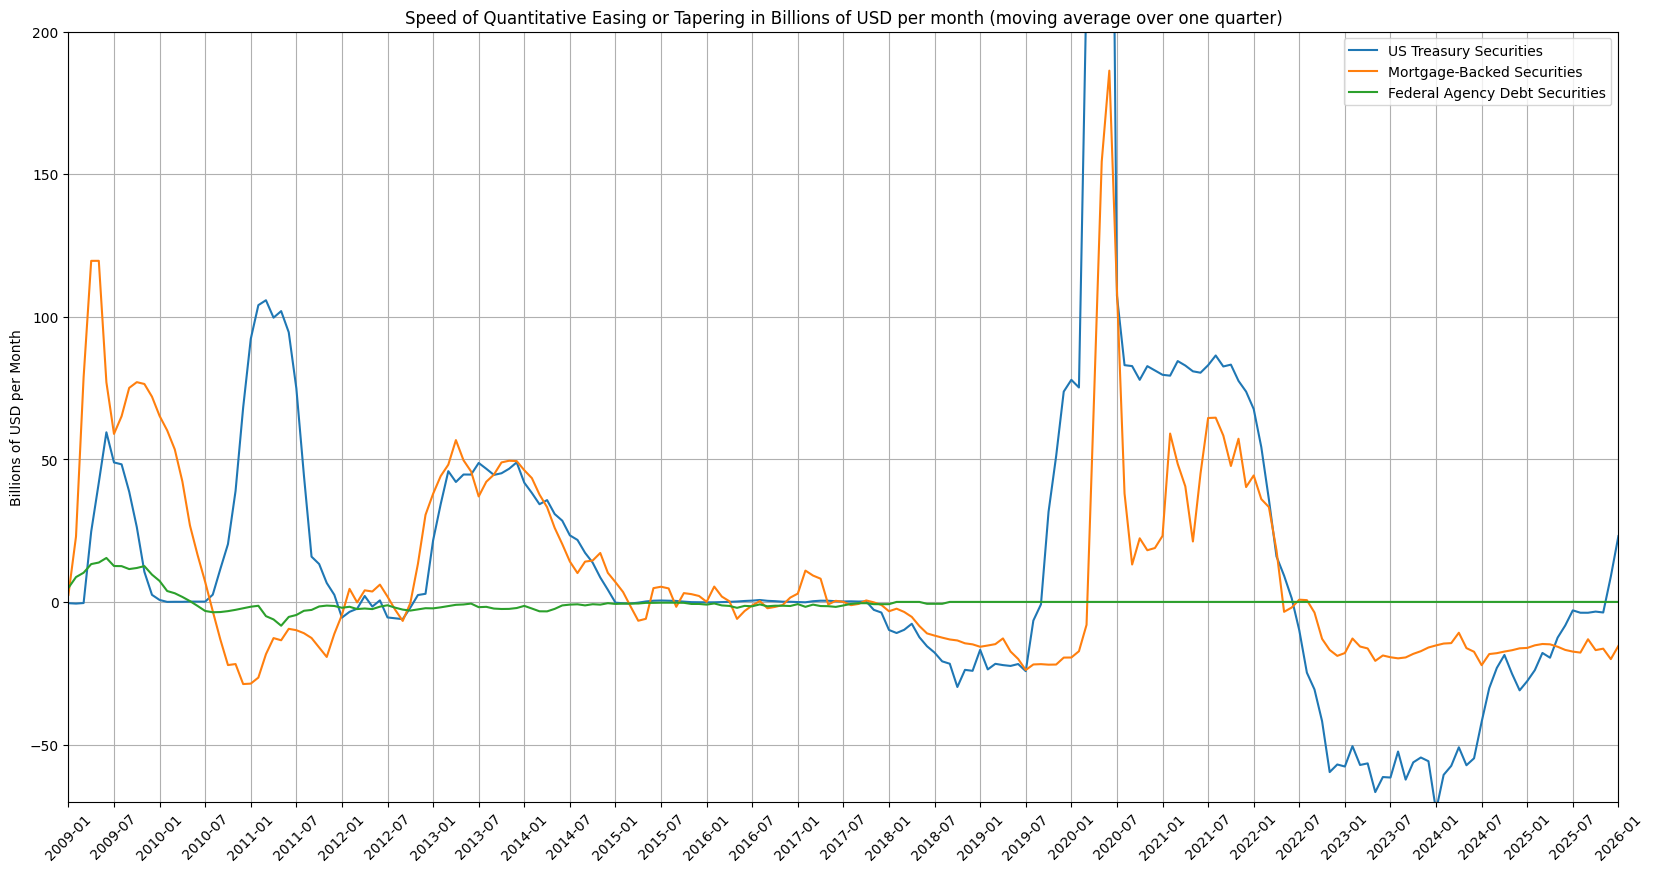

In [18]:
ax = sec_held_outright_speed_ma.iloc[:,:3].plot(figsize=(20,10), grid=True,
                            title=SEC_HELD_OUTRIGHT_SPEED_MA,
                            xticks=sec_held_outright_speed_ma.index[::6], xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL_SPEED, ylim=(-70, 200))#, yticks=np.arange(-30, 21, 5))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sec_held_outright_speed_ma.index[::6])))

### Measuring the speed of quantitative easing/tapering in Billions of USD per quarter
#### Resampling to quarterly frequencies

In [19]:
# Resampling to quarter start
sec_held_outright_2 = sec_held_outright.resample('QS').last()

In [20]:
sec_held_outright_2

,US Treasury Securities,Mortgage-Backed Securities,Federal Agency Debt Securities,Loans,Repurchase Agreeents
DATE,,,,,
2008-10-01,$475.92bn,$0.00bn,$19.71bn,$193.87bn,$80.00bn
2009-01-01,$474.75bn,$236.16bn,$50.39bn,$136.23bn,$0.00bn
2009-04-01,$653.19bn,$467.23bn,$96.63bn,$132.66bn,$0.00bn
2009-07-01,$769.16bn,$692.37bn,$131.18bn,$110.33bn,$0.00bn
2009-10-01,$776.59bn,$908.26bn,$159.88bn,$89.70bn,$0.00bn
...,...,...,...,...,...
2025-01-01,"$4,237.42bn","$2,189.00bn",$2.35bn,$4.09bn,$0.00bn
2025-04-01,"$4,212.62bn","$2,138.50bn",$2.35bn,$8.01bn,$0.02bn
2025-07-01,"$4,201.21bn","$2,099.22bn",$2.35bn,$8.51bn,$0.00bn


In [21]:
sec_held_outright_speed_2 = (sec_held_outright_2 - sec_held_outright_2.shift(1)).dropna()

In [22]:
sec_held_outright_speed_2

,US Treasury Securities,Mortgage-Backed Securities,Federal Agency Debt Securities,Loans,Repurchase Agreeents
DATE,,,,,
2009-01-01,$-1.18bn,$236.16bn,$30.69bn,$-57.65bn,$-80.00bn
2009-04-01,$178.45bn,$231.07bn,$46.23bn,$-3.57bn,$0.00bn
2009-07-01,$115.97bn,$225.14bn,$34.55bn,$-22.33bn,$0.00bn
2009-10-01,$7.43bn,$215.89bn,$28.70bn,$-20.63bn,$0.00bn
2010-01-01,$0.12bn,$160.44bn,$9.11bn,$-8.99bn,$0.00bn
...,...,...,...,...,...
2025-01-01,$-53.69bn,$-44.26bn,$0.00bn,$-5.54bn,$0.00bn
2025-04-01,$-24.80bn,$-50.50bn,$0.00bn,$3.92bn,$0.02bn
2025-07-01,$-11.40bn,$-39.28bn,$0.00bn,$0.50bn,$-0.01bn


## Total changes in main asset ownership since start of tapering
Having looked at monthly changes, let's have a look at the aggregate amounts of tapering since its start in June 2022 and the regional banking crisis in March 2023.

In [23]:
# From dates
periods = [date(2022, 6, 1), date(2023, 3, 1)]

In [24]:
df_changes = pd.DataFrame(
    [(sec_held_outright.iloc[-1] - sec_held_outright.loc[pd.to_datetime(period)]).iloc[[0,1,3]] for period in periods], 
    index=['Since {:%Y-%m-%d}'.format(period) for period in periods])

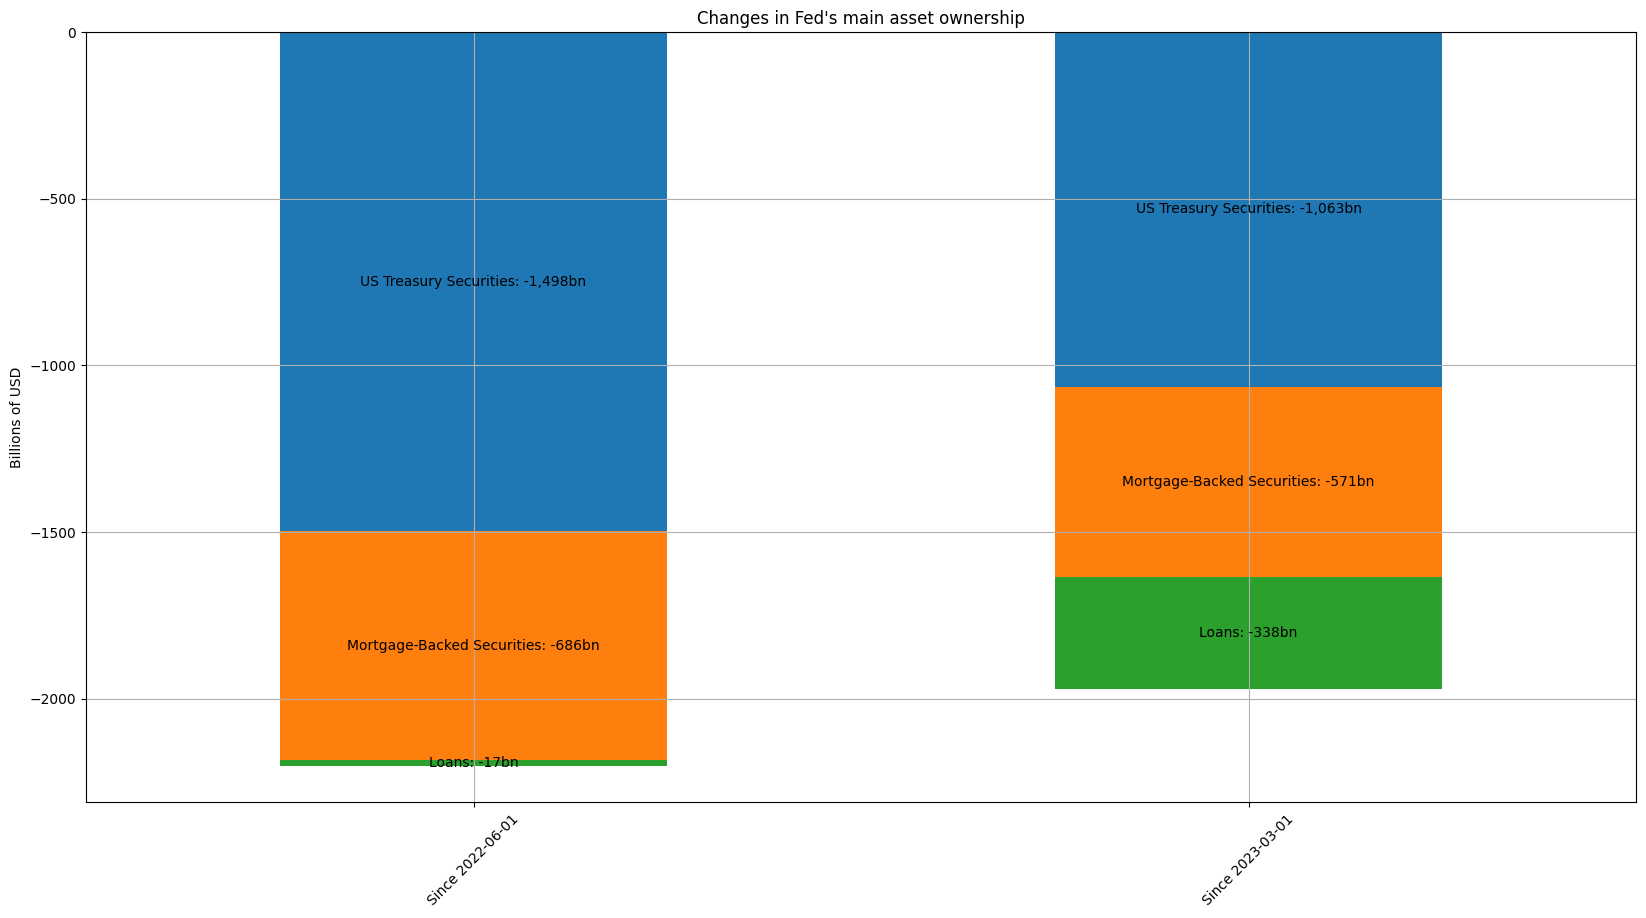

In [25]:
ax = df_changes.plot.bar(figsize=(20,10), grid=True, title="Changes in Fed's main asset ownership",
                         stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:+,.0f}bn', label_type='center')

In [26]:
idx = sec_held_outright_speed_2.index.get_loc('2023-04-01')
print('A total of ${:.0f}bn ({:.2%}) of ${:.0f} in emergency loans to banks issued in March paid back'
      .format(sec_held_outright_speed_2.iloc[idx:,3].sum(),
              -sec_held_outright_speed_2.iloc[idx:,3].sum()/sec_held_outright_speed_2.iloc[idx-1,3],
              sec_held_outright_speed_2.iloc[idx-1,3]))
print('\t${:.0f}bn left to pay back'.format(
    sec_held_outright_speed_2.iloc[idx-1,3] + sec_held_outright_speed_2.iloc[idx:,3].sum()))

A total of $-338bn (103.54%) of $327 in emergency loans to banks issued in March paid back
	$-12bn left to pay back


In [27]:
total_balance = sec_held_outright.sum(axis=1)

In [28]:
print('Since start of tapering in {:%Y-%m-%d} balance sheet reduced by ${:,.0f}bn'
      .format(periods[0], total_balance.loc[pd.to_datetime(periods[0])] - total_balance.iloc[-1]))

Since start of tapering in 2022-06-01 balance sheet reduced by $2,201bn
